<a href="https://colab.research.google.com/github/bbbbdragon/python-pype-lang-3/blob/master/macbeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Is this a vector which I see before me? - Using RNN's with ROBERTA vectorizations to find "creepy" passages in Shakespeare's "MacBeth"

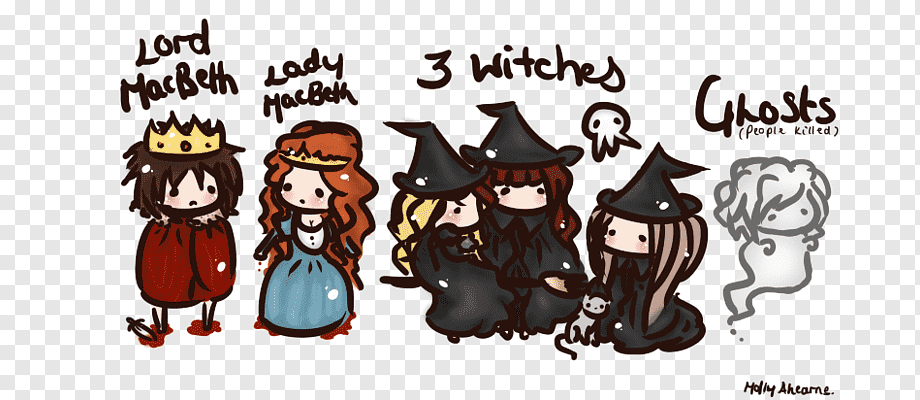

The Scottish Play has received a lot of attention recently as the prime example of a work of literature that is "creepy", "ominous", "foreboding".  The key word is "the" used with MacBeth talking about his eyes, arms, hands, hinting at dissociation from himself.  We're going to do something a little different.  We're going to show how we can use a small amount of data to identify passages that refer to three things:

* Battles
* Weapons
* People getting hurt or injured

While MacBeth refers to these topics quite genrously, we can't really assume that the majority of the play's text will mention this.  The conventional approach will be to synthesize training data using a T5 paraphraser, and then run a classifier on the synthesized data.

However, we are going to try something a bit different.  We're going to train an RNN, which is extremely data-hungry, on a minimal amount of labelled data.  However, the labelled data will be extremely rich.  RNN's data-hungriness derives from the fact that they are usually trained on one-hot vectors referring to characters or even words.  This forces them to learn the multiple dependencies between letters and words before they can producing meaningful content or classify sequences meaningfully.

However, what happens if we use extremely rich representations of the data, that encode all the dependencies that RNN's have to learn from scratch?  Will this allow them to evade their characteristic data-hungriness?   That is the question we will explore in this notebook.  We are going to take the ROBERTA vectorization of every verse of MacBeth, model character's lines as a sequence, and attempt to build an RNN classifier for the "gloomy" content mentioned above.  Our hypothesis is that this will allow to build a rather sophisticated classifier with a miminum of labelled data, because the RNN is learning only the encodings of this content across vectorizations.

I hope this will allow people to deal with TP-sparse data sets characteristic of environments such as compliance, fraud-detection, legal literature, where the relevant content tends to manifest itself in very indirect ways.

In this notebook, we will:

* Parse the text from MacBeth
* Label the text
* Vectorize the text
* Train an RNN classifier on the labeled text
* Classify the text
* Rank passages according to their relevance

## Assumptions behind the data representation

A simple Recurrent Neural Network (RNN) can be represented in terms of two weight matrices `W` and `V`, an observable `v`, a state vector `h`, and an activator function `f`.  At time `t+1`, we compute the next state vector as:

image.png

For classification purposes, we can compute a label vector `y` as:

image.png

The underlying assumption with an RNN is that it attempts to detect cyclicality in the observations.  `V` implies a natural momentum to the state vectors, which is modified by `W` and `v`.  One could think of this as a journey from the northernmost point of a sphere, southward, and then back up north.  The observables affect the latitude of `h`.  

Because of this, they are capable of capturing short-term and long-term dependencies in sequences such as letters or words.  However, in order for these to be learned properly, the data has to contain all of the combinatorics in proper proportion.  As such, while they are quite effective at classification, vectorization, and natural language generation, these models can be quite data-hungry.

Transformer models are now the state-of-the-art in sequence generation and classification.  They have broken through most NLP benchmarks quite effectively.  Particularly in sentence vectorization, they are very sensitive to both lexical and syntactic content.  However, in production they can introduce certain bottlenecks, as they are large and computationally expensive.  This has significant budgetary implications.

One thing I have noticed in practice is that transformer vectorizations can also be used quite effectively as input to simpler models.  For example, I have seen logits run on BERT vectorizations for classification purposes.  This is not "transfer learning" in the strictest sense, as transfer learning involves fine-tuning the coefficients of the original transformer to complete a designated task.  However, it could be seen as something along the lines of transfer learning, since all the syntactic, semantic, and lexical information is already encoded in the vector, and a simpler model can learn these features.

If an RNN can work on richer vectorizations than the typical one-hot or word2vec data, it is possible that it can learn higher-level abstractions in the text, such as discourse, allusion, metaphor.  If it can do this with not-very-common language (such as Shakespeare) then it can do it with other sparse, poorly annotated datasets such as email, chat, or legal-bureaucratic language.

## Architecture

In this project, we take poetic passages from MacBeth.  One passage from one speaker is a "line", and each verse in the passage is an observable in the sequence.  We will be using Facebook's Distilled Roberta model to vectorize the verses, and we will be applying layer normalization to these vectors to smooth them and make them easier to process by the RNN.  If the line contains at least one reference to weapons, injury, or violence, then the line is marked as a positive example.  We only mark a small subset of lines, and rank them according to relevance.  For log-softmax probabilities of positive and negative classification, `p_p` and `p_n`, we define relevance as `p_p - p_n`.  Because these are logarithms, this can be seen as a quotient of the orignal probabilities. 

# Implementation

We will be building an RNN using pytorch.  Our vectorizations will come from spacy's transformer vectorizer.  A lot of the pre-and-post processing will be done in pype.  I recommend you run this project on a GPU in high-RAM mode.

## Installation of libraries

Please restart your runtime after you install these libraries, so that the spacy model is found.

In [ ]:
!pip install python-pype-lang-3
!pip install torch
!pip install spacy_sentence_bert

     |████████████████████████████████| 45 kB 1.5 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 3.0 MB 30.0 MB/s 
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 5.8 MB 32.5 MB/s 
     |████████████████████████████████| 621 kB 55.9 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 456 kB 68.8 MB/s 
     |████████████████████████████████| 10.1 MB 56.2 MB/s 
     |████████████████████████████████| 2.6 MB 37.0 MB/s 
     |████████████████████████████████| 1.2 MB 52.9 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 895 kB 46.4 MB/s 
     |████████████████████████████████| 3.3 MB 39.2 MB/s 
     |████████████████████████████████| 636 kB 39.5 MB/s 
  Created wheel for spacy-s

## Imports

In [ ]:
from pype3 import short_pp
from pype3 import pypeify,pypeify_namespace,p,_,_0,_1,_2,_3,_last,a,ep,db,l,lm,cl,app,m,ifta
from pype3 import tup,iff,ifp,change,select,squash,ift,d,dm,cl_has,cl_if,consec,ext
from pype3.helpers import *
from pype3.loaders import *
from pype3.string_helpers import *
from pype3.numpy_helpers import *
from pype3.func_helpers import *
import numpy as np
import pprint as pp
import sys
import spacy
import numpy as np
import re
import pprint as pp
import spacy_sentence_bert
import torch.nn as nn
import json
import random

## Constants for sentence processing

In [ ]:
NAME_RE=re.compile(r'[A-Z]{3}')
NLP=spacy_sentence_bert.load_model('en_paraphrase_distilroberta_base_v1')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Dividing the text into lines

Please ensure that you have uploaded "macbeth.txt" into your file system.  It is also helpful to have "labeled.json" if you do not want to do any reloading.

In [ ]:
from pype3 import _

def re_filter(re,st):
  '''
  If there is no match, return True.
  '''
  return not re.match(st)


def line_tuples(lines,nameRe=NAME_RE):
  '''
  Takes a list of verses and puts them into embedded lists.
  '''
  ({(re_filter,nameRe,_.text)}, # Filter lines that do not have names associated with them.
   ls << _,
   enumerate, # We are going to separate lines by the empty string.
   {~_1}, # Where are the empty strings?
   [_0], # Get the indices of the empty strings.
   (zip,_,_[1:]), # Zip consecutive indices of empty strings.
   [ls[_0:_1]], # Everything between these indices is a line.
   [{_}], # Filter out empty embedded lists.
   {len > 3}, # Take only lines that have 4 or more verses.
  )


def parse_file(fileName):
  '''
  Read lines of the file and parse it with line_tuples.
  '''
  (load_list_file,
   line_tuples,
  )

  
pypeify_namespace(locals(),True)

texts=parse_file('macbeth.txt')
texts

[['This is the sergeant',
  'Who, like a good and hardy soldier, fought',
  '’Gainst my captivity.—Hail, brave friend!',
  'Say to the King the knowledge of the broil',
  'As thou didst leave it.'],
 ['Doubtful it stood;',
  'As two spent swimmers that do cling together',
  'And choke their art. The merciless Macdonwald',
  '(Worthy to be a rebel, for to that',
  'The multiplying villainies of nature',
  'Do swarm upon him) from the Western Isles',
  'Of kerns and gallowglasses is supplied;',
  'And Fortune, on his damned quarrel smiling,',
  'Show’d like a rebel’s whore. But all’s too weak;',
  'For brave Macbeth (well he deserves that name),',
  'Disdaining Fortune, with his brandish’d steel,',
  'Which smok’d with bloody execution,',
  'Like Valour’s minion, carv’d out his passage,',
  'Till he fac’d the slave;',
  'Which ne’er shook hands, nor bade farewell to him,',
  'Till he unseam’d him from the nave to the chops,',
  'And fix’d his head upon our battlements.'],
 ['As whence th

## Labelling of the texts

This labels the text as positive and negative.  However, as this process may be a bit tedious, you may want to just load 'labeled.json' into your file system instead.

In [ ]:
from pype3 import _

def label_texts(tups):
  '''
  Function to label jsons to train the RNN.
  '''
  labels=[]

  for (i,dct) in enumerate(tups):

    print(dct['line'])
    inpt=input()
    labelDct={'label':0}

    if inpt == 'q':

      return labels

    if inpt:

      labelDct={'label':1}

    labels.append({**labelDct,**dct})

  return labels


def run_labeling(docs):
  '''
  Wrapper for label_texts.
  '''
  (enumerate,
   [(cartesian_ls,_0,_1)],
   flatten_list,
   [{'lineIndex':_0,
     'line':_1,
    }],
   label_texts,
   (merge_ls_dct_no_key,_,'lineIndex'),
   dct_values,
  )

pypeify_namespace(locals(),True)

labeled=run_labeling(texts)

with open('labeled.json','w') as f:

  f.write(json.dumps(labeled))

labeled

This is the sergeant

Who, like a good and hardy soldier, fought
1
’Gainst my captivity.—Hail, brave friend!

Say to the King the knowledge of the broil
1
As thou didst leave it.

Doubtful it stood;

As two spent swimmers that do cling together

And choke their art. The merciless Macdonwald
1
(Worthy to be a rebel, for to that

The multiplying villainies of nature

Do swarm upon him) from the Western Isles

Of kerns and gallowglasses is supplied;

And Fortune, on his damned quarrel smiling,
1
Show’d like a rebel’s whore. But all’s too weak;

For brave Macbeth (well he deserves that name),

Disdaining Fortune, with his brandish’d steel,
1
Which smok’d with bloody execution,
1
Like Valour’s minion, carv’d out his passage,
1
Till he fac’d the slave;

Which ne’er shook hands, nor bade farewell to him,

Till he unseam’d him from the nave to the chops,
1
And fix’d his head upon our battlements.

As whence the sun ’gins his reflection

Shipwracking storms and direful thunders break,

So from 

[[{'label': 0, 'line': 'This is the sergeant'},
  {'label': 1, 'line': 'Who, like a good and hardy soldier, fought'},
  {'label': 0, 'line': '’Gainst my captivity.—Hail, brave friend!'},
  {'label': 1, 'line': 'Say to the King the knowledge of the broil'},
  {'label': 0, 'line': 'As thou didst leave it.'}],
 [{'label': 0, 'line': 'Doubtful it stood;'},
  {'label': 0, 'line': 'As two spent swimmers that do cling together'},
  {'label': 1, 'line': 'And choke their art. The merciless Macdonwald'},
  {'label': 0, 'line': '(Worthy to be a rebel, for to that'},
  {'label': 0, 'line': 'The multiplying villainies of nature'},
  {'label': 0, 'line': 'Do swarm upon him) from the Western Isles'},
  {'label': 0, 'line': 'Of kerns and gallowglasses is supplied;'},
  {'label': 1, 'line': 'And Fortune, on his damned quarrel smiling,'},
  {'label': 0, 'line': 'Show’d like a rebel’s whore. But all’s too weak;'},
  {'label': 0, 'line': 'For brave Macbeth (well he deserves that name),'},
  {'label': 1, '

## Vectorizing the text

Here we will apply the ROBERTA model to the training data, with their labels.

In [ ]:
from pype3 import _

def vectorize_training(lines,nlp=NLP):

  (enumerate,
   [(cartesian_ls,_0,_1)],
   flatten_list,
   indices << [_0],
   labels << [_1.label],
   [_1.line],
   (zip,labels,lm(nlp.pipe)),
   [{'label':_0,
     'doc':_1}],
   (zip,indices,_),
   tup_ls_dct,
   dct_values, 
  )


pypeify_namespace(locals(),True)

with open('labeled.json','r') as f:

  labeled=json.loads(f.read())

vectorizedTraining=vectorize_training(labeled)
vectorizedTraining

[[{'doc': This is the sergeant, 'label': 0},
  {'doc': Who, like a good and hardy soldier, fought, 'label': 1},
  {'doc': ’Gainst my captivity.—Hail, brave friend!, 'label': 0},
  {'doc': Say to the King the knowledge of the broil, 'label': 1},
  {'doc': As thou didst leave it., 'label': 0}],
 [{'doc': Doubtful it stood;, 'label': 0},
  {'doc': As two spent swimmers that do cling together, 'label': 0},
  {'doc': And choke their art. The merciless Macdonwald, 'label': 1},
  {'doc': (Worthy to be a rebel, for to that, 'label': 0},
  {'doc': The multiplying villainies of nature, 'label': 0},
  {'doc': Do swarm upon him) from the Western Isles, 'label': 0},
  {'doc': Of kerns and gallowglasses is supplied;, 'label': 0},
  {'doc': And Fortune, on his damned quarrel smiling,, 'label': 1},
  {'doc': Show’d like a rebel’s whore. But all’s too weak;, 'label': 0},
  {'doc': For brave Macbeth (well he deserves that name),, 'label': 0},
  {'doc': Disdaining Fortune, with his brandish’d steel,, 'la

## Vectorize texts

This function applies the ROBERTA model to all of the examples given.

In [ ]:
from pype3 import _

def vectorize_texts(lines,nlp=NLP):

  (enumerate,
   [(cartesian_ls,_0,_1)],
   flatten_list,
   indices << [_0],
   [_1],
   lm(nlp.pipe),
   (zip,indices,_),
   tup_ls_dct,
   dct_values, 
  )

pypeify_namespace(locals(),True)

vectorized=vectorize_texts(texts)
vectorized

[[This is the sergeant,
  Who, like a good and hardy soldier, fought,
  ’Gainst my captivity.—Hail, brave friend!,
  Say to the King the knowledge of the broil,
  As thou didst leave it.],
 [Doubtful it stood;,
  As two spent swimmers that do cling together,
  And choke their art. The merciless Macdonwald,
  (Worthy to be a rebel, for to that,
  The multiplying villainies of nature,
  Do swarm upon him) from the Western Isles,
  Of kerns and gallowglasses is supplied;,
  And Fortune, on his damned quarrel smiling,,
  Show’d like a rebel’s whore. But all’s too weak;,
  For brave Macbeth (well he deserves that name),,
  Disdaining Fortune, with his brandish’d steel,,
  Which smok’d with bloody execution,,
  Like Valour’s minion, carv’d out his passage,,
  Till he fac’d the slave;,
  Which ne’er shook hands, nor bade farewell to him,,
  Till he unseam’d him from the nave to the chops,,
  And fix’d his head upon our battlements.],
 [As whence the sun ’gins his reflection,
  Shipwracking st

## Constants for the RNN

These constants will allow us to build an RNN.

In [ ]:
N_FEATURES=vectorizedTraining[0][0]['doc'].vector.shape[0]
HIDDEN_SIZE=128
N_CATEGORIES=2
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
CRITERION=nn.NLLLoss()
LEARNING_RATE=0.001
NUM_ITERS=1000
EVERY=50

## The RNN

Here, we define the RNN in a class called NormalizedRNN.  This will take a hidden state dimension of 128, which is smaller than the observable dimension, and will output both state observables and categories.  Note that we are using the abstraction that an RNN can be implemented as:

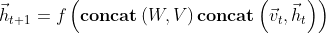

We must explain the particular reasoning behind several decisions in this architecture.

* The normalization of the input ensures that elements in the input vector are "smoother" in the sense of being lower variance and higher similarity to one another.  This will allow the RNN to detect patterns much more easily by not being thrown off by "jagged" outliers.
* The activator function is a ReLu, which is a well-known alternative to the sigmoid that prevents vanishing gradients.
* The log softmax for the output probabilities allows the output to have a probabilistic interpretation of the output, while being able to compute the relevance as a signed quotient - positive only if the positive probability is greater than the negative probability.

In [15]:
class NormalizedRNN(nn.Module):

  def __init__(self, inputSize, hiddenSize, outputSize):

    super(NormalizedRNN, self).__init__()

    self.hidden_size=hiddenSize # Dimension of hidden state vectors.
    self.normalize=nn.LayerNorm(inputSize + hiddenSize) # Normalization for input.
    self.i2h=nn.Linear(inputSize + hiddenSize, hiddenSize) # Linear layer for concatenated vectors.
    self.relu=nn.ReLU() # Activator for i2h.
    self.i2o=nn.Linear(inputSize+hiddenSize,outputSize) # Classification output.
    self.softmax=nn.LogSoftmax(dim=1) # Softmax for classification.


  def forward(self, input, hidden):

    combined=torch.cat((input, hidden),1) # Concatenate h and v
    normalized=self.normalize(combined) # Normalize combined.
    hidden=self.i2h(normalized) # Compute the normalized coefficient.
    hidden=self.relu(hidden) # Apply activator
    output=self.i2o(normalized) # Apply classifier.
    output=self.softmax(output) # Apply softmax to output.

    return output,hidden

  def initHidden(self):

    return torch.zeros(1, self.hidden_size)

R=NormalizedRNN(N_FEATURES,HIDDEN_SIZE,N_CATEGORIES)
R.to(DEVICE)
R

NormalizedRNN(
  (normalize): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
  (i2h): Linear(in_features=896, out_features=128, bias=True)
  (relu): ReLU()
  (i2o): Linear(in_features=896, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [16]:
from pype3 import _

def category_tensor(label,device=DEVICE):
  '''
  Wrapper to build the category tensor - one dimensional 1 or 0.
  '''                 
  categoryTensor=torch.tensor([label], dtype=torch.long,device=device) # Note we want to store the tensor on the GPU.

  return categoryTensor


def line_tensor(docs,vecSize=N_FEATURES,device=DEVICE):
  '''
  Wrapper to build the line tensor.  For a sequence of n verses, each having
  a vectorization of k dimensions, the tensor will be a k x n matrix.
  '''
  tensor=torch.zeros(len(docs),1,vecSize,device=device) # Initiate the matrix.

  # Now, we populate the matrix with vectors of each verse.
  for (i,doc) in enumerate(docs):

    tensor[i][0]=torch.from_numpy(doc.vector)
  
  return tensor


def random_training(vectorizedTraining):
  '''
  '''
  (lm(random.choice),
   {'categoryTensor':ep([_.label],
                        max,
                        category_tensor,
                       ), 
    'lineTensor':ep([_.doc],
                    line_tensor,
                   ),
    'docs':[_.doc],
   },
  )


def rnn_forward(lineTensor,rnn,device=DEVICE):

  hidden=rnn.initHidden().to(device)

  rnn.zero_grad()

  for i in range(lineTensor.size()[0]):

    output, hidden=rnn.forward(lineTensor[i], hidden)

  return output,hidden


def get_category(labelTensor):

  return 'negative' if labelTensor[0][0].item() > labelTensor[0][1].item() else 'positive'


def relevance(labelTensor):

  return labelTensor[0][1].item() - labelTensor[0][0].item()


def classify(testingExample,rnn):

  (docs << _,
   line_tensor,
   (rnn_forward,_,rnn),
   {'label':_0,
    'docs':docs},
   a('category',(get_category,_.label)),
   a('relevance',(relevance,_.label)), 
  )

def random_testing(testingExamples,rnn):

  (lm(random.choice),
   (classify,_,rnn),
  )


def classify_all(vectorized,rnn):

  ([(classify,_,rnn)],
   (sort_by_key,_,'relevance',True)
  )


pypeify_namespace(locals(),True)

def train_iter(categoryTensor,lineTensor,rnn,criterion,learningRate,device=DEVICE):

  output,hidden=rnn_forward(lineTensor,rnn)

  loss=criterion(output,categoryTensor)

  loss.backward()

  for p in rnn.parameters():

      p.data.add_(p.grad.data, alpha=-learningRate)

  return output, loss.item()
  

def train(vectorizedTraining,testingExamples,rnn,criterion,learningRate,numIters,every):

  for i in range(1,numIters):

    tensorJS=random_training(vectorizedTraining)
    output,loss=train_iter(tensorJS['categoryTensor'], tensorJS['lineTensor'],rnn,criterion,learningRate)

    if i % every == 0:

      print('*'*30)
      print(f'at iteration {i}')
      print(loss)

      #testingJS=random_testing(testingExamples,rnn)

      #short_pp(testingJS)
    

train(vectorizedTraining,vectorized,R,CRITERION,LEARNING_RATE,NUM_ITERS,EVERY)

******************************
at iteration 50
0.11770716309547424
******************************
at iteration 100
0.07497505098581314
******************************
at iteration 150
0.02500457875430584
******************************
at iteration 200
0.03325771540403366
******************************
at iteration 250
0.03556976839900017
******************************
at iteration 300
0.01075059175491333
******************************
at iteration 350
0.01179105881601572
******************************
at iteration 400
0.016639266163110733
******************************
at iteration 450
0.013406721875071526
******************************
at iteration 500
0.009441959671676159
******************************
at iteration 550
0.013444477692246437
******************************
at iteration 600
0.01281808689236641
******************************
at iteration 650
0.002172492677345872
******************************
at iteration 700
0.0070573813281953335
******************************
at iteratio

[{'category': 'positive',
  'docs': [Now does he feel,
   His secret murders sticking on his hands;,
   Now minutely revolts upbraid his faith-breach;,
   Those he commands move only in command,,
   Nothing in love: now does he feel his title,
   Hang loose about him, like a giant’s robe,
   Upon a dwarfish thief.],
  'label': tensor([[-2.7995, -0.0628]], device='cuda:0', grad_fn=<LogSoftmaxBackward>),
  'relevance': 2.7367531433701515},
 {'category': 'positive',
  'docs': [Threescore and ten I can remember well,,
   Within the volume of which time I have seen,
   Hours dreadful and things strange, but this sore night,
   Hath trifled former knowings.],
  'label': tensor([[-2.5559, -0.0808]], device='cuda:0', grad_fn=<LogSoftmaxBackward>),
  'relevance': 2.475148729979992},
 {'category': 'positive',
  'docs': [The night has been unruly: where we lay,,
   Our chimneys were blown down and, as they say,,
   Lamentings heard i’ th’ air, strange screams of death,,
   And prophesying, with a

In [ ]:
classified=classify_all(vectorized[len(vectorizedTraining):],R)
classified